# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**

## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%matplotlib inline
warnings.filterwarnings('ignore')


# 1. Data Validation

## A. Check descriptive statistics, duplicated data, and missing values

In [378]:
df = pd.read_csv('./data/recipe_site_traffic_2212.csv')
display(df)

print("Data Types: ")
display(df.info())


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Data Types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


None

### a. Fixing Data Types

The servings column data type is wrong as it should be an integer type, so I will change it. But, there is a problem because servings have string values like '4 as a snack' and '6 as a snack' so I can't just change the data type, I need to encode the values first.

In [379]:
df['servings'].value_counts()


servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [380]:
replacement_dict = {'4 as a snack': '4', '6 as a snack': '6'}
df['servings'].replace(replacement_dict, inplace=True)
print(df['servings'].value_counts())
df['servings'] = df['servings'].astype('category')


servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64


In [381]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      947 non-null    object  
 6   servings      947 non-null    category
 7   high_traffic  574 non-null    object  
dtypes: category(1), float64(4), int64(1), object(2)
memory usage: 53.0+ KB


### b. Data Exploration With Descriptive Statistics

In [382]:
print("Descriptive Statistics: ")
display(df.describe())
display(df.describe(include=['O']))


Descriptive Statistics: 


,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


,category,high_traffic
count,947,574
unique,11,1
top,Breakfast,High
freq,106,574


From the nominal (text) statstical description above, I can see anomalies in both columns (category and high_traffic). First, The category column have 11 unique values as opposed to the data description that states the column have 10 unique values, so I need to encode the anomaly to make the unique values to ten and match the description. 

In [383]:
df['category'].value_counts()


category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

In [384]:
replacement_dict = {'Chicken Breast': 'Chicken'}
df['category'].replace(replacement_dict, inplace=True)
df['category'] = df['category'].astype('category')
print(df['category'].value_counts())


category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Dessert           83
Vegetable         83
Meat              79
One Dish Meal     71
Name: count, dtype: int64


I replaced the 'Chicken Breast' value to 'Chicken' with the assumption that 'Chicken' category consists all of the chicken parts in the meal.

Then regarding the 'high_traffic' column, it only have one unique value which is 'high' traffic and null in the other data. So it's safe to assume that the other is 'low' traffic and make it a binary category. I can't assume that there is also 'medium' traffic because I don't know what the threshold is for 'medium' traffic.	

In [385]:
df['high_traffic'].value_counts()


high_traffic
High    574
Name: count, dtype: int64

Fill the null values with 'low' in the 'high_traffic' column and change the data type to categorical. 

In [386]:
df['high_traffic'].fillna('Low', inplace=True)
df['high_traffic'] = df['high_traffic'].astype('category')
df['high_traffic'].value_counts()


high_traffic
High    574
Low     373
Name: count, dtype: int64

In [387]:
print("Missing Values: ")
display(df.isna().sum())

print("Missing Value Percentage: ")
display(df.isna().sum() / len(df))


Missing Values: 


recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

Missing Value Percentage: 


recipe          0.00000
calories        0.05491
carbohydrate    0.05491
sugar           0.05491
protein         0.05491
category        0.00000
servings        0.00000
high_traffic    0.00000
dtype: float64

There are missing values in calories, carbohydrate, sugar, protein. The columns with missing values have distributions that are very skewed (right-skewed) so, I imputed it with median because median is less sensitive to outliers than  mean.

<Axes: >

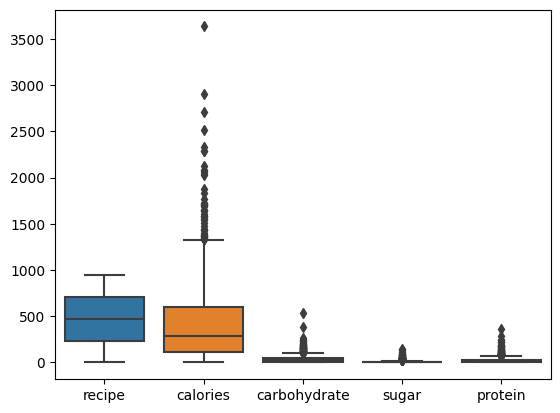

In [388]:
sns.boxplot(df)


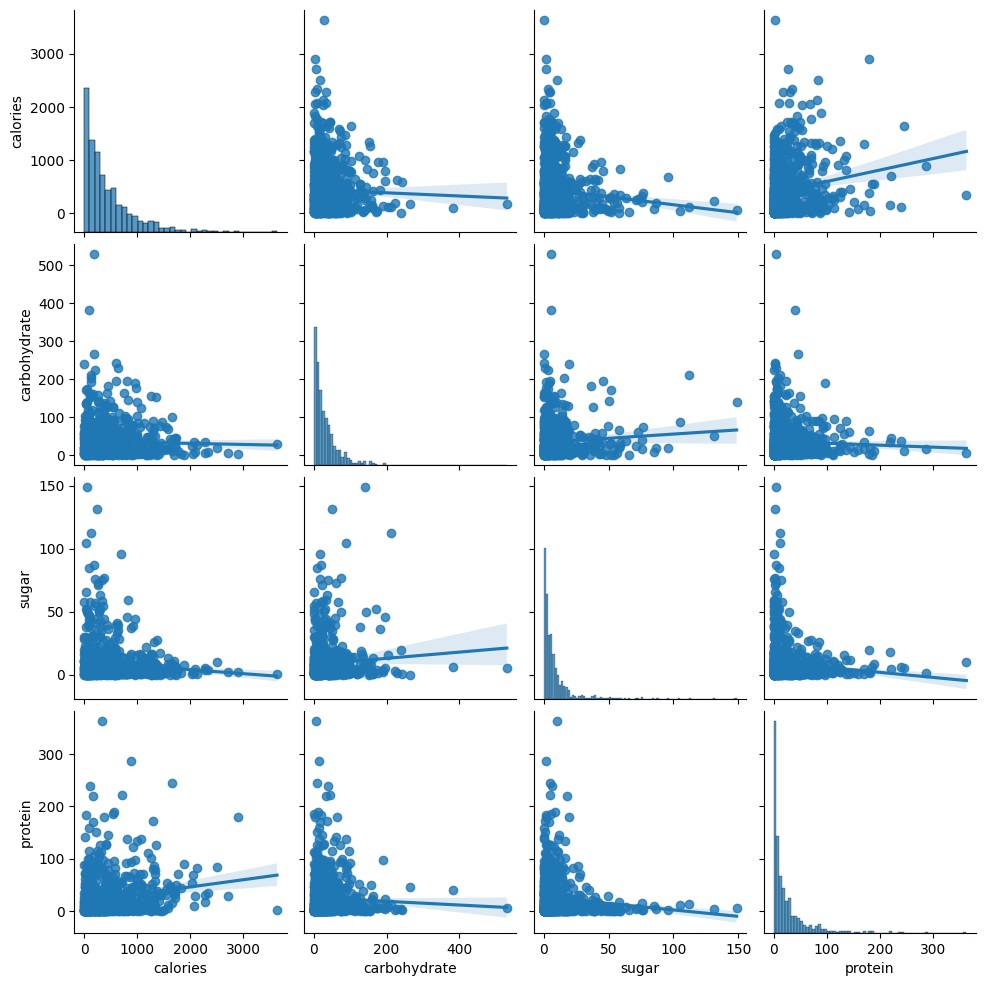

In [389]:
sns.pairplot(df.loc[:, ['calories', 'carbohydrate', 'sugar', 'protein']], kind='reg');


In [390]:
calories_mean, calories_median = df['calories'].mean(), df['calories'].median()
carbohydrate_mean, carbohydrate_median = df['carbohydrate'].mean(), df['carbohydrate'].median()
sugar_mean, sugar_median = df['sugar'].mean(), df['sugar'].median()
protein_mean, protein_median = df['protein'].mean(), df['protein'].median()

df['calories'].fillna(calories_median, inplace=True)
df['carbohydrate'].fillna(carbohydrate_median, inplace=True)
df['sugar'].fillna(sugar_median, inplace=True)
df['protein'].fillna(protein_median, inplace=True)


In [391]:
print("Missing Values: ")
display(df.isna().sum())


Missing Values: 


recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [392]:
print("Duplicated Recipe Values: ")
display(df.duplicated(subset='recipe').sum())

print("Unique Values: ")
display(df.nunique())


Duplicated Recipe Values: 


0

Unique Values: 


recipe          947
calories        891
carbohydrate    835
sugar           666
protein         772
category         10
servings          4
high_traffic      2
dtype: int64

In [393]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      947 non-null    float64 
 2   carbohydrate  947 non-null    float64 
 3   sugar         947 non-null    float64 
 4   protein       947 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    category
 7   high_traffic  947 non-null    category
dtypes: category(3), float64(4), int64(1)
memory usage: 40.6 KB


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation